<a href="https://colab.research.google.com/github/rogerbalcells/CS687Final/blob/main/monte_carlo_tree_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1 — Imports

from __future__ import annotations

import math
from dataclasses import dataclass, field
from typing import Any, Callable, Dict, Optional, Tuple, List

import numpy as np
import matplotlib.pyplot as plt
import os, sys, json, csv, time

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive")

BASE_DIR = "/content/drive/MyDrive/rl_project_results" if IN_COLAB else "./rl_project_results"
os.makedirs(BASE_DIR, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
class Gridworld687:

    ACTIONS = ("AU", "AD", "AL", "AR")
    gamma = 0.9

    def __init__(self, seed: int = 0):
        self.rng = np.random.default_rng(seed)

        self.n_rows = 5
        self.n_cols = 5

        self.obstacles = {(2, 2), (3, 2)}
        self.goal_coord = (4, 4)
        self.water_coord = (4, 2)

        self.state_to_coord = {
            1:(0,0),  2:(0,1),  3:(0,2),  4:(0,3),  5:(0,4),
            6:(1,0),  7:(1,1),  8:(1,2),  9:(1,3), 10:(1,4),
            11:(2,0), 12:(2,1),          13:(2,3), 14:(2,4),
            15:(3,0), 16:(3,1),          17:(3,3), 18:(3,4),
            19:(4,0), 20:(4,1), 21:(4,2), 22:(4,3), 23:(4,4),
        }
        self.coord_to_state = {v: k for k, v in self.state_to_coord.items()}
        assert self.coord_to_state[self.goal_coord] == 23
        assert self.coord_to_state[self.water_coord] == 21

        self.reset()

    def reset(self, state: int = 1) -> int:
        self.s = int(state)
        return self.s

    @staticmethod
    def _turn_left(a: str) -> str:
        return {"AU": "AL", "AL": "AD", "AD": "AR", "AR": "AU"}[a]

    @staticmethod
    def _turn_right(a: str) -> str:
        return {"AU": "AR", "AR": "AD", "AD": "AL", "AL": "AU"}[a]

    def is_terminal(self, s: int) -> bool:
        return s == 23

    def _move(self, coord: Tuple[int, int], action: str) -> Tuple[int, int]:
        r, c = coord
        if action == "AU":
            r2, c2 = r - 1, c
        elif action == "AD":
            r2, c2 = r + 1, c
        elif action == "AL":
            r2, c2 = r, c - 1
        elif action == "AR":
            r2, c2 = r, c + 1
        else:
            raise ValueError(f"Unknown action: {action}")

        if not (0 <= r2 < self.n_rows and 0 <= c2 < self.n_cols):
            return coord
        if (r2, c2) in self.obstacles:
            return coord
        return (r2, c2)

    def sample_step_from(
        self,
        s: int,
        action: str,
        rng: Optional[np.random.Generator] = None
    ) -> Tuple[int, float, bool]:
        rng = self.rng if rng is None else rng

        if self.is_terminal(s):
            return s, 0.0, True

        u = rng.random()
        if u < 0.8:
            a_eff = action
        elif u < 0.85:
            a_eff = self._turn_right(action)
        elif u < 0.90:
            a_eff = self._turn_left(action)
        else:
            a_eff = None

        coord = self.state_to_coord[s]
        next_coord = coord if a_eff is None else self._move(coord, a_eff)
        s2 = self.coord_to_state[next_coord]

        if s2 == 21:
            r = -10.0
        elif s2 == 23:
            r = +10.0
        else:
            r = 0.0

        done = self.is_terminal(s2)
        return s2, r, done

    def step(self, action: str) -> Tuple[int, float, bool]:
        s2, r, done = self.sample_step_from(self.s, action)
        self.s = s2
        return s2, r, done

    def render(self, s: Optional[int] = None) -> str:
        s = self.s if s is None else int(s)
        out = []
        for r in range(self.n_rows):
            row = []
            for c in range(self.n_cols):
                if (r, c) in self.obstacles:
                    cell = " ### "
                else:
                    st = self.coord_to_state[(r, c)]
                    if st == 23:
                        cell = " G23 "
                    elif st == 21:
                        cell = " W21 "
                    else:
                        cell = f" {st:02d} "
                if self.state_to_coord[s] == (r, c):
                    cell = "[" + cell[1:-1] + "]"
                row.append(cell)
            out.append("".join(row))
        return "\n".join(out)


# quick sanity check
env_gw = Gridworld687(seed=0)
print(env_gw.render())


[01] 02  03  04  05 
 06  07  08  09  10 
 11  12  ###  13  14 
 15  16  ###  17  18 
 19  20  W21  22  G23 


In [3]:
class MountainCar687:
    ACTIONS = (-1, 0, 1)
    gamma = 1.0

    x_min, x_max = -1.2, 0.5
    v_min, v_max = -0.07, 0.07

    def __init__(self, seed: int = 0):
        self.rng = np.random.default_rng(seed)
        self.reset()

    def reset(self) -> np.ndarray:
        x0 = self.rng.uniform(-0.6, -0.4)
        self.s = np.array([x0, 0.0], dtype=np.float64)
        return self.s.copy()

    def is_terminal(self, s: np.ndarray) -> bool:
        return float(s[0]) >= self.x_max - 1e-12

    def sample_step_from(self, s: np.ndarray, a: int) -> Tuple[np.ndarray, float, bool]:
        x, v = float(s[0]), float(s[1])

        if self.is_terminal(s):
            return np.array([self.x_max, 0.0], dtype=np.float64), 0.0, True

        a = int(a)
        v2 = v + 0.001 * a - 0.0025 * math.cos(3.0 * x)
        v2 = min(max(v2, self.v_min), self.v_max)

        x2 = x + v2
        x2 = min(max(x2, self.x_min), self.x_max)

        if x2 <= self.x_min + 1e-12 or x2 >= self.x_max - 1e-12:
            v2 = 0.0

        s2 = np.array([x2, v2], dtype=np.float64)
        done = self.is_terminal(s2)
        r = 0.0 if done else -1.0
        return s2, r, done

    def step(self, a: int) -> Tuple[np.ndarray, float, bool]:
        s2, r, done = self.sample_step_from(self.s, a)
        self.s = s2
        return s2.copy(), r, done


# quick sanity check
env_mc = MountainCar687(seed=0)
s0 = env_mc.reset()
print("s0:", s0)
for _ in range(3):
    s0, r, d = env_mc.step(1)
    print(" ->", s0, r, d)


s0: [-0.54604266  0.        ]
 -> [-0.54487446  0.0011682 ] -1.0 False
 -> [-0.54254679  0.00232766] -1.0 False
 -> [-0.5390771   0.00346969] -1.0 False


In [4]:
@dataclass
class MCTSNode:
    state_key: Any
    actions: Tuple[Any, ...]
    n: int = 0
    n_sa: Dict[Any, int] = field(default_factory=dict)
    w_sa: Dict[Any, float] = field(default_factory=dict)
    children: Dict[Any, Dict[Any, "MCTSNode"]] = field(default_factory=dict)

    def __post_init__(self):
        for a in self.actions:
            self.n_sa.setdefault(a, 0)
            self.w_sa.setdefault(a, 0.0)
            self.children.setdefault(a, {})

    def q_hat(self, a: Any) -> float:
        n = self.n_sa[a]
        return (self.w_sa[a] / n) if n > 0 else 0.0


def _ucb(q: float, n_parent: int, n_sa: int, c: float) -> float:
    if n_sa == 0:
        return float("inf")
    return q + c * math.sqrt(math.log(n_parent + 1.0) / n_sa)


def eps_constant(eps: float):
    return lambda n_visits: float(eps)

def eps_linear(eps_start: float, eps_min: float, N: int):
    def f(n_visits: int):
        t = min(max(int(n_visits), 0), int(N))
        eps = eps_start + (eps_min - eps_start) * (t / float(N))
        return float(max(eps_min, eps))
    return f

def eps_exponential(eps_start: float, eps_min: float, decay: float):
    def f(n_visits: int):
        eps = eps_start * (float(decay) ** max(int(n_visits), 0))
        return float(max(eps_min, eps))
    return f


class MCTSPlanner:
    def __init__(
        self,
        actions: Tuple[Any, ...],
        step_fn: Callable[[Any, Any, np.random.Generator], Tuple[Any, float, bool]],
        state_key_fn: Callable[[Any], Any],
        gamma: float,
        max_depth: int = 200,
        seed: int = 0,
        tree_policy: str = "ucb",
        c_ucb: float = 1.414,
        eps_schedule: Optional[Callable[[int], float]] = None,
        force_untried_actions: bool = True,
        # rollout
        rollout_policy: Optional[Callable[[Any, np.random.Generator], Any]] = None,
    ):
        self.actions = tuple(actions)
        self.step_fn = step_fn
        self.state_key_fn = state_key_fn
        self.gamma = float(gamma)
        self.max_depth = int(max_depth)
        self.rng = np.random.default_rng(seed)

        self.tree_policy = str(tree_policy)
        self.c_ucb = float(c_ucb)
        self.eps_schedule = eps_schedule
        self.force_untried_actions = bool(force_untried_actions)
        self.rollout_policy = rollout_policy

        self.root: Optional[MCTSNode] = None
        self.model_calls_total: int = 0

    def reset_tree(self):
        self.root = None

    def reset_model_call_counter(self):
        self.model_calls_total = 0

    def _step_model(self, s, a):
        self.model_calls_total += 1
        return self.step_fn(s, a, self.rng)

    def _get_or_make_root(self, state) -> MCTSNode:
        key = self.state_key_fn(state)
        if self.root is None or self.root.state_key != key:
            self.root = MCTSNode(state_key=key, actions=self.actions)
        return self.root

    def plan(self, state, n_simulations: int) -> Any:
        root = self._get_or_make_root(state)
        for _ in range(int(n_simulations)):
            self._simulate(state, root, depth=0)
        return max(self.actions, key=lambda a: root.n_sa[a])

    def observe_transition_and_reuse(self, next_state, action_taken):
        if self.root is None:
            self.root = MCTSNode(state_key=self.state_key_fn(next_state), actions=self.actions)
            return
        next_key = self.state_key_fn(next_state)
        child = self.root.children.get(action_taken, {}).get(next_key)
        self.root = child if child is not None else MCTSNode(state_key=next_key, actions=self.actions)

    def _select_action(self, node: MCTSNode) -> Any:
        if self.force_untried_actions:
            untried = [a for a in self.actions if node.n_sa[a] == 0]
            if untried:
                return untried[int(self.rng.integers(0, len(untried)))]

        if self.tree_policy == "ucb":
            best_a, best_score = None, -float("inf")
            for a in self.actions:
                score = _ucb(node.q_hat(a), node.n, node.n_sa[a], self.c_ucb)
                if score > best_score:
                    best_score, best_a = score, a
            return best_a

        if self.tree_policy == "eps_greedy":
            eps = float(self.eps_schedule(node.n)) if self.eps_schedule is not None else 0.1
            if self.rng.random() < eps:
                return self.actions[int(self.rng.integers(0, len(self.actions)))]
            qs = np.array([node.q_hat(a) for a in self.actions], dtype=float)
            best = np.flatnonzero(qs == np.max(qs))
            return self.actions[int(self.rng.choice(best))]

        raise ValueError(f"Unknown tree_policy={self.tree_policy}")

    def _rollout(self, state, depth: int) -> float:
        if depth >= self.max_depth:
            return 0.0
        G, disc = 0.0, 1.0
        s = state
        for _ in range(depth, self.max_depth):
            a = self.rollout_policy(s, self.rng) if self.rollout_policy else self.actions[int(self.rng.integers(0, len(self.actions)))]
            s, r, done = self._step_model(s, a)
            G += disc * r
            if done:
                break
            disc *= self.gamma
        return G

    def _simulate(self, state, node: MCTSNode, depth: int) -> float:
        if depth >= self.max_depth:
            return 0.0

        node.n += 1
        a = self._select_action(node)
        s2, r, done = self._step_model(state, a)
        s2_key = self.state_key_fn(s2)

        child = node.children[a].get(s2_key)
        expanded = (child is None)
        if expanded:
            child = MCTSNode(state_key=s2_key, actions=self.actions)
            node.children[a][s2_key] = child

        if done:
            G = r
        else:
            G = r + self.gamma * (self._rollout(s2, depth + 1) if expanded else self._simulate(s2, child, depth + 1))

        node.n_sa[a] += 1
        node.w_sa[a] += G
        return G


def running_mean(x: np.ndarray, w: int) -> np.ndarray:
    if len(x) < w:
        return np.array([])
    c = np.cumsum(np.insert(x, 0, 0.0))
    return (c[w:] - c[:-w]) / w


Gridworld MCTS SINGLE stage starting...
  configs=39, runs/cfg=4, episodes=90, max_steps=200, budget=30
[001/39] ucb:ucb_c=0.3_D30                        | succ=1.000 steps=29.4 ret=0.980 calls=21812 | elapsed=0.8 min
[002/39] ucb:ucb_c=0.5_D30                        | succ=1.000 steps=28.7 ret=1.117 calls=21712 | elapsed=1.4 min
[003/39] ucb:ucb_c=0.9_D30                        | succ=1.000 steps=26.8 ret=1.221 calls=19886 | elapsed=2.1 min
[004/39] ucb:ucb_c=1.4_D30                        | succ=1.000 steps=27.2 ret=1.228 calls=20615 | elapsed=2.7 min
[005/39] ucb:ucb_c=2.0_D30                        | succ=1.000 steps=25.1 ret=1.245 calls=19110 | elapsed=3.3 min
[006/39] ucb:ucb_c=2.5_D30                        | succ=1.000 steps=27.0 ret=1.175 calls=20456 | elapsed=3.9 min
[007/39] eps_greedy:eps_const_0.05_D30            | succ=1.000 steps=30.8 ret=0.870 calls=23192 | elapsed=5.0 min
[008/39] eps_greedy:eps_const_0.10_D30            | succ=1.000 steps=27.4 ret=1.194 calls=20498 | 

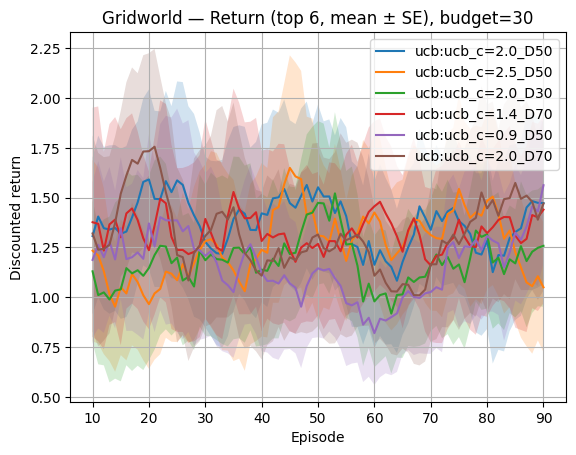

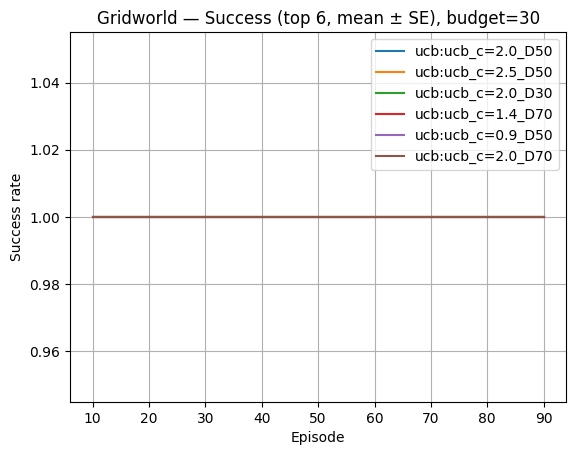

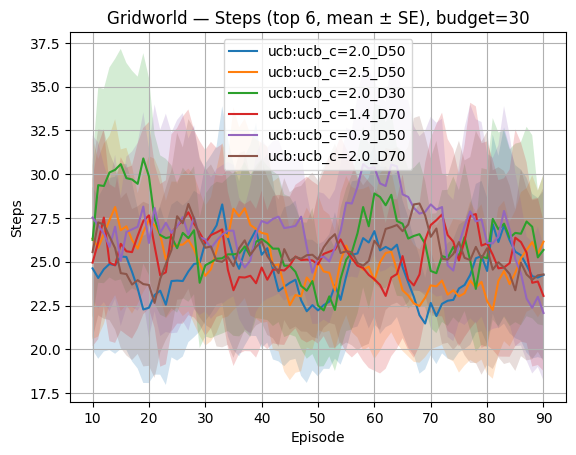

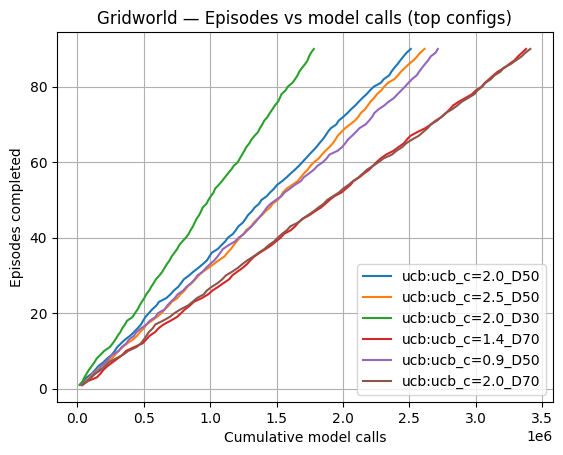

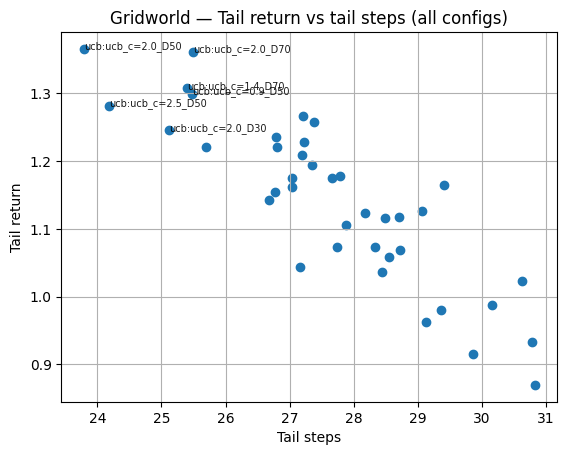


Best config (SINGLE stage):
{'tree_policy': 'ucb', 'name': 'ucb_c=2.0', 'max_depth': 50, 'c_ucb': 2.0, 'succ': 1.0, 'steps': 23.791666666666668, 'ret': 1.3654675851540479, 'calls': 27234.333333333332, 'label': 'ucb:ucb_c=2.0_D50', 'idx': 17}
MSE(V^pi, V*): 6.682107

Induced policy grid (best config):
 R   D   D   D   U 
 U   R   D   R   D 
 R   U   X   U   D 
 L   L   X   R   D 
 U   U   W   R   G 

Results directory: /content/drive/MyDrive/rl_project_results/mcts_gridworld_single


In [5]:
OUT_DIR = os.path.join(BASE_DIR, "mcts_gridworld_single")
os.makedirs(OUT_DIR, exist_ok=True)

def savefig(name: str):
    plt.savefig(os.path.join(OUT_DIR, name), dpi=200, bbox_inches="tight")

def gridworld_transition_model(env: Gridworld687):
    transitions = {s: {a: [] for a in env.ACTIONS} for s in env.state_to_coord.keys()}

    def effs(a):
        return [
            (0.8, a),
            (0.05, env._turn_right(a)),
            (0.05, env._turn_left(a)),
            (0.10, None),
        ]

    for s in env.state_to_coord.keys():
        for a in env.ACTIONS:
            if env.is_terminal(s):
                transitions[s][a] = [(1.0, s, 0.0, True)]
                continue

            probs: Dict[int, float] = {}
            for p, a_eff in effs(a):
                coord = env.state_to_coord[s]
                nxt_coord = coord if a_eff is None else env._move(coord, a_eff)
                s2 = env.coord_to_state[nxt_coord]
                probs[s2] = probs.get(s2, 0.0) + p

            out = []
            for s2, p in probs.items():
                r = -10.0 if s2 == 21 else (+10.0 if s2 == 23 else 0.0)
                out.append((p, s2, r, env.is_terminal(s2)))
            transitions[s][a] = out

    return transitions

def value_iteration_gridworld(transitions, gamma: float, theta: float = 1e-12):
    states = sorted(transitions.keys())
    actions = list(next(iter(transitions.values())).keys())
    v = {s: 0.0 for s in states}
    while True:
        delta = 0.0
        for s in states:
            q_vals = []
            for a in actions:
                q = 0.0
                for p, s2, r, done in transitions[s][a]:
                    q += p * (r + (0.0 if done else gamma * v[s2]))
                q_vals.append(q)
            new_v = float(np.max(q_vals))
            delta = max(delta, abs(new_v - v[s]))
            v[s] = new_v
        if delta < theta:
            break
    return v

def policy_evaluation_gridworld(transitions, policy: Dict[int, str], gamma: float, theta: float = 1e-12):
    states = sorted(transitions.keys())
    v = {s: 0.0 for s in states}
    while True:
        delta = 0.0
        for s in states:
            a = policy.get(s, None)
            if a is None:
                continue
            new_v = 0.0
            for p, s2, r, done in transitions[s][a]:
                new_v += p * (r + (0.0 if done else gamma * v[s2]))
            delta = max(delta, abs(new_v - v[s]))
            v[s] = float(new_v)
        if delta < theta:
            break
    return v

def print_policy_grid(policy: Dict[int, str], env: Gridworld687):
    arrows = {"AU": "U", "AD": "D", "AL": "L", "AR": "R"}
    for r in range(env.n_rows):
        row = []
        for c in range(env.n_cols):
            if (r, c) in env.obstacles:
                row.append(" X ")
            else:
                s = env.coord_to_state[(r, c)]
                if s == 23:
                    row.append(" G ")
                elif s == 21:
                    row.append(" W ")
                else:
                    row.append(f" {arrows.get(policy.get(s, None), '.')} ")
        print(" ".join(row))

def eps_constant(eps0: float):
    def f(ep: int) -> float:
        return float(eps0)
    return f

def eps_linear(eps0: float, eps_min: float, N: int):
    def f(ep: int) -> float:
        t = min(max(ep, 0), N)
        return float(max(eps_min, eps0 + (t / float(N)) * (eps_min - eps0)))
    return f

def eps_exponential(eps0: float, eps_min: float, decay: float):
    def f(ep: int) -> float:
        return float(max(eps_min, eps0 * (decay ** ep)))
    return f

def running_mean(x: np.ndarray, w: int) -> np.ndarray:
    if len(x) < w:
        return np.array([])
    c = np.cumsum(np.insert(x, 0, 0.0))
    return (c[w:] - c[:-w]) / w

def mcts_gridworld_run(
    sims_per_decision: int,
    num_episodes: int,
    max_steps: int,
    seed: int,
    max_depth: int,
    tree_policy: str,
    c_ucb: float,
    eps_schedule: Optional[Callable[[int], float]],
    reuse_tree_within_episode: bool = True,
):
    env = Gridworld687(seed=seed)

    def step_fn(s, a, rng):
        return env.sample_step_from(s, a, rng)

    planner = MCTSPlanner(
        actions=env.ACTIONS,
        step_fn=step_fn,
        state_key_fn=lambda s: s,
        gamma=env.gamma,
        max_depth=int(max_depth),
        seed=seed,
        tree_policy=tree_policy,
        c_ucb=float(c_ucb),
        eps_schedule=eps_schedule,
        force_untried_actions=True,
        rollout_policy=None,
    )

    rets = np.zeros(num_episodes, dtype=float)
    steps = np.zeros(num_episodes, dtype=int)
    succ = np.zeros(num_episodes, dtype=int)
    model_calls = np.zeros(num_episodes, dtype=int)

    for ep in range(num_episodes):
        env.reset(1)
        planner.reset_tree()
        planner.reset_model_call_counter()

        s = env.s
        G, disc = 0.0, 1.0

        for t in range(max_steps):
            a = planner.plan(s, n_simulations=int(sims_per_decision))
            s2, r, done = env.step(a)

            if reuse_tree_within_episode:
                planner.observe_transition_and_reuse(s2, a)
            else:
                planner.reset_tree()

            G += disc * r
            disc *= env.gamma
            s = s2
            if done:
                succ[ep] = 1
                steps[ep] = t + 1
                break
        else:
            steps[ep] = max_steps

        rets[ep] = G
        model_calls[ep] = planner.model_calls_total

    return rets, steps, succ, model_calls

def induced_policy_from_mcts(env: Gridworld687, sims_per_decision: int, seed: int, max_depth: int,
                            tree_policy: str, c_ucb: float, eps_schedule: Optional[Callable[[int], float]]):
    T = gridworld_transition_model(env)

    def step_fn(s, a, rng):
        return env.sample_step_from(s, a, rng)

    planner = MCTSPlanner(
        actions=env.ACTIONS,
        step_fn=step_fn,
        state_key_fn=lambda s: s,
        gamma=env.gamma,
        max_depth=int(max_depth),
        seed=seed,
        tree_policy=tree_policy,
        c_ucb=float(c_ucb),
        eps_schedule=eps_schedule,
        force_untried_actions=True,
        rollout_policy=None,
    )

    policy = {}
    for s in sorted(T.keys()):
        if env.is_terminal(s):
            continue
        planner.reset_tree()
        a = planner.plan(s, n_simulations=int(sims_per_decision))
        policy[s] = a
    return policy

env0 = Gridworld687(seed=0)
T_exact = gridworld_transition_model(env0)
v_star = value_iteration_gridworld(T_exact, gamma=env0.gamma, theta=1e-12)

BUDGET = 30
RUNS = 4
EPISODES = 90
MAX_STEPS = 200
TAIL = 30
TOPK = 6
SMOOTH_W = 10

UCB_C_CHOICES = [0.3, 0.5, 0.9, 1.4, 2.0, 2.5]
MAX_DEPTH_CHOICES = [30, 50, 70]
EPS_CONFIGS = [
    ("eps_const_0.05",            eps_constant(0.05)),
    ("eps_const_0.10",            eps_constant(0.10)),
    ("eps_const_0.20",            eps_constant(0.20)),
    ("eps_lin_0.30_to_0.05_N60",  eps_linear(0.30, 0.05, N=60)),
    ("eps_lin_0.20_to_0.05_N60",  eps_linear(0.20, 0.05, N=60)),
    ("eps_exp_0.30_d0.97_floor",  eps_exponential(0.30, 0.05, decay=0.97)),
    ("eps_exp_0.30_d0.95_floor",  eps_exponential(0.30, 0.05, decay=0.95)),
]
eps_lookup = dict(EPS_CONFIGS)

configs: List[Dict[str, Any]] = []
for md in MAX_DEPTH_CHOICES:
    for c in UCB_C_CHOICES:
        configs.append({"tree_policy": "ucb", "name": f"ucb_c={c}", "c_ucb": float(c), "eps_name": "", "max_depth": int(md)})
    for ename, _ in EPS_CONFIGS:
        configs.append({"tree_policy": "eps_greedy", "name": ename, "c_ucb": 0.0, "eps_name": ename, "max_depth": int(md)})

n_cfg = len(configs)
rets_all = np.zeros((n_cfg, RUNS, EPISODES), dtype=float)
steps_all = np.zeros((n_cfg, RUNS, EPISODES), dtype=int)
succ_all = np.zeros((n_cfg, RUNS, EPISODES), dtype=int)
calls_all = np.zeros((n_cfg, RUNS, EPISODES), dtype=int)

print("Gridworld MCTS SINGLE stage starting...")
print(f"  configs={n_cfg}, runs/cfg={RUNS}, episodes={EPISODES}, max_steps={MAX_STEPS}, budget={BUDGET}")

rows: List[Dict[str, Any]] = []
t0 = time.time()

for i, cfg in enumerate(configs):
    label = f"{cfg['tree_policy']}:{cfg['name']}_D{cfg['max_depth']}"
    for run in range(RUNS):
        seed = 100000 + 1000 * i + run
        rets, st, su, mc = mcts_gridworld_run(
            sims_per_decision=BUDGET,
            num_episodes=EPISODES,
            max_steps=MAX_STEPS,
            seed=seed,
            max_depth=cfg["max_depth"],
            tree_policy=cfg["tree_policy"],
            c_ucb=cfg["c_ucb"],
            eps_schedule=(None if cfg["tree_policy"] == "ucb" else eps_lookup[cfg["eps_name"]]),
            reuse_tree_within_episode=True,
        )
        rets_all[i, run] = rets
        steps_all[i, run] = st
        succ_all[i, run] = su
        calls_all[i, run] = mc

    tail_succ = float(succ_all[i, :, -TAIL:].mean())
    tail_steps = float(steps_all[i, :, -TAIL:].mean())
    tail_ret = float(rets_all[i, :, -TAIL:].mean())
    tail_calls = float(calls_all[i, :, -TAIL:].mean())

    rows.append({
        "tree_policy": cfg["tree_policy"],
        "name": cfg["name"],
        "max_depth": int(cfg["max_depth"]),
        "c_ucb": float(cfg["c_ucb"]),
        "succ": tail_succ,
        "steps": tail_steps,
        "ret": tail_ret,
        "calls": tail_calls,
        "label": label,
        "idx": i,
    })

    elapsed = time.time() - t0
    print(f"[{i+1:03d}/{n_cfg}] {label:40s} | succ={tail_succ:.3f} steps={tail_steps:.1f} ret={tail_ret:.3f} calls={tail_calls:.0f} | elapsed={elapsed/60:.1f} min")
    sys.stdout.flush()

rows.sort(key=lambda d: (-d["succ"], d["steps"], -d["ret"], d["calls"]))

csv_path = os.path.join(OUT_DIR, "single_stage_sweep.csv")
with open(csv_path, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=["tree_policy","name","max_depth","c_ucb","succ","steps","ret","calls"])
    w.writeheader()
    for d in rows:
        w.writerow({k: d[k] for k in ["tree_policy","name","max_depth","c_ucb","succ","steps","ret","calls"]})

best = rows[0]
best_idx = int(best["idx"])
best_cfg = configs[best_idx]

meta_path = os.path.join(OUT_DIR, "single_stage_meta.json")
with open(meta_path, "w") as f:
    json.dump({
        "BUDGET": BUDGET, "RUNS": RUNS, "EPISODES": EPISODES, "MAX_STEPS": MAX_STEPS,
        "TAIL": TAIL, "TOPK": TOPK, "SMOOTH_W": SMOOTH_W,
        "configs": configs,
        "best": best,
    }, f, indent=2)

npz_path = os.path.join(OUT_DIR, "single_stage_arrays.npz")
np.savez(
    npz_path,
    rets=rets_all.astype(np.float32),
    steps=steps_all.astype(np.int16),
    succ=succ_all.astype(np.int8),
    calls=calls_all.astype(np.int32),
)

print("\nGridworld SINGLE stage ranking — top 15:")
for d in rows[:15]:
    print(f"  {d['tree_policy']:10s} {d['name']:26s} D={d['max_depth']:2d} | succ={d['succ']:.3f} steps={d['steps']:.1f} ret={d['ret']:.3f} calls={d['calls']:.0f}")
print(f"\nSaved CSV: {csv_path}")
print(f"Saved NPZ: {npz_path}")
print(f"Saved META: {meta_path}")

top_idxs = [int(d["idx"]) for d in rows[:TOPK]]
top_labels = [rows[k]["label"] for k in range(TOPK)]

plt.figure()
for idx, lab in zip(top_idxs, top_labels):
    R = rets_all[idx]
    mean = R.mean(axis=0)
    se = R.std(axis=0) / np.sqrt(RUNS)
    rm = running_mean(mean, SMOOTH_W)
    rm_se = running_mean(se, SMOOTH_W)
    x = np.arange(len(rm)) + SMOOTH_W
    plt.plot(x, rm, label=lab)
    plt.fill_between(x, rm - rm_se, rm + rm_se, alpha=0.2)
plt.xlabel("Episode"); plt.ylabel("Discounted return")
plt.title(f"Gridworld — Return (top {TOPK}, mean ± SE), budget={BUDGET}")
plt.grid(True); plt.legend()
savefig("single_stage_return_topk.png")
plt.show()

plt.figure()
for idx, lab in zip(top_idxs, top_labels):
    S = succ_all[idx].astype(float)
    mean = S.mean(axis=0)
    se = S.std(axis=0) / np.sqrt(RUNS)
    rm = running_mean(mean, SMOOTH_W)
    rm_se = running_mean(se, SMOOTH_W)
    x = np.arange(len(rm)) + SMOOTH_W
    plt.plot(x, rm, label=lab)
    plt.fill_between(x, rm - rm_se, rm + rm_se, alpha=0.2)
plt.xlabel("Episode"); plt.ylabel("Success rate")
plt.title(f"Gridworld — Success (top {TOPK}, mean ± SE), budget={BUDGET}")
plt.grid(True); plt.legend()
savefig("single_stage_success_topk.png")
plt.show()

plt.figure()
for idx, lab in zip(top_idxs, top_labels):
    L = steps_all[idx].astype(float)
    mean = L.mean(axis=0)
    se = L.std(axis=0) / np.sqrt(RUNS)
    rm = running_mean(mean, SMOOTH_W)
    rm_se = running_mean(se, SMOOTH_W)
    x = np.arange(len(rm)) + SMOOTH_W
    plt.plot(x, rm, label=lab)
    plt.fill_between(x, rm - rm_se, rm + rm_se, alpha=0.2)
plt.xlabel("Episode"); plt.ylabel("Steps")
plt.title(f"Gridworld — Steps (top {TOPK}, mean ± SE), budget={BUDGET}")
plt.grid(True); plt.legend()
savefig("single_stage_steps_topk.png")
plt.show()

plt.figure()
for idx, lab in zip(top_idxs, top_labels):
    M = calls_all[idx].astype(float)
    cum_model = np.cumsum(M, axis=1).mean(axis=0)
    plt.plot(cum_model, np.arange(1, EPISODES + 1), label=lab)
plt.xlabel("Cumulative model calls"); plt.ylabel("Episodes completed")
plt.title("Gridworld — Episodes vs model calls (top configs)")
plt.grid(True); plt.legend()
savefig("single_stage_episodes_vs_modelcalls_topk.png")
plt.show()

plt.figure()
xs = [d["steps"] for d in rows]
ys = [d["ret"] for d in rows]
plt.scatter(xs, ys)
for d in rows[:TOPK]:
    plt.annotate(d["label"], (d["steps"], d["ret"]), fontsize=7, alpha=0.9)
plt.xlabel("Tail steps"); plt.ylabel("Tail return")
plt.title("Gridworld — Tail return vs tail steps (all configs)")
plt.grid(True)
savefig("single_stage_tail_scatter.png")
plt.show()

print("\nBest config (SINGLE stage):")
print(best)

pi_best = induced_policy_from_mcts(
    env0,
    sims_per_decision=BUDGET,
    seed=0,
    max_depth=best_cfg["max_depth"],
    tree_policy=best_cfg["tree_policy"],
    c_ucb=best_cfg["c_ucb"],
    eps_schedule=(None if best_cfg["tree_policy"] == "ucb" else eps_lookup[best_cfg["eps_name"]]),
)
v_pi = policy_evaluation_gridworld(T_exact, pi_best, gamma=env0.gamma, theta=1e-12)
states_nt = [s for s in T_exact.keys() if not env0.is_terminal(s)]
mse = float(np.mean([(v_pi[s] - v_star[s]) ** 2 for s in states_nt]))
print(f"MSE(V^pi, V*): {mse:.6f}")

print("\nInduced policy grid (best config):")
print_policy_grid(pi_best, env0)
print(f"\nResults directory: {OUT_DIR}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MountainCar MCTS SINGLE stage starting...
  configs=18, runs/cfg=20, eps/cfg=10, max_steps=200, budget=15, max_depth_planning=80
[01/18] bins=(12,10) rollout=random   c=0.3 | succ=0.000 steps=200.0 ret=-200.00 calls=240000 | elapsed=16.5 min
[02/18] bins=(12,10) rollout=random   c=1.0 | succ=0.000 steps=200.0 ret=-200.00 calls=240000 | elapsed=32.6 min
[03/18] bins=(12,10) rollout=random   c=2.0 | succ=0.000 steps=200.0 ret=-200.00 calls=240000 | elapsed=48.6 min
[04/18] bins=(12,10) rollout=momentum c=0.3 | succ=0.280 steps=186.9 ret=-186.65 calls=208112 | elapsed=52.3 min
[05/18] bins=(12,10) rollout=momentum c=1.0 | succ=0.210 steps=180.6 ret=-180.34 calls=206862 | elapsed=55.7 min
[06/18] bins=(12,10) rollout=momentum c=2.0 | succ=0.430 steps=153.2 ret=-152.79 calls=165361 | elapsed=58.5 min
[07/18] bins=(18,14) rollout=random   c=0.3 | succ=0.000 steps=2

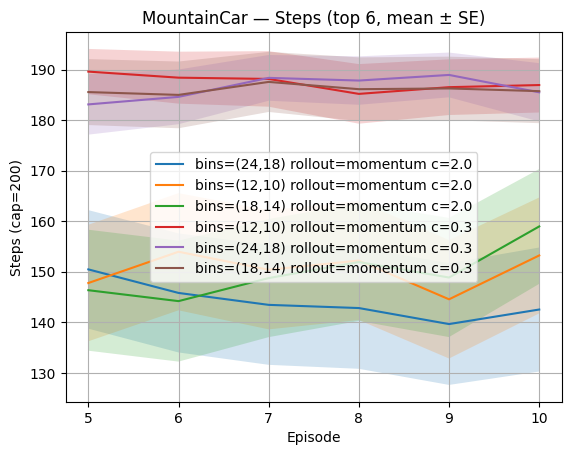

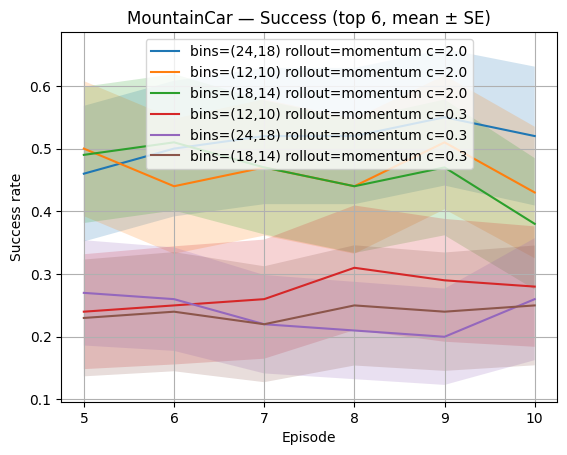

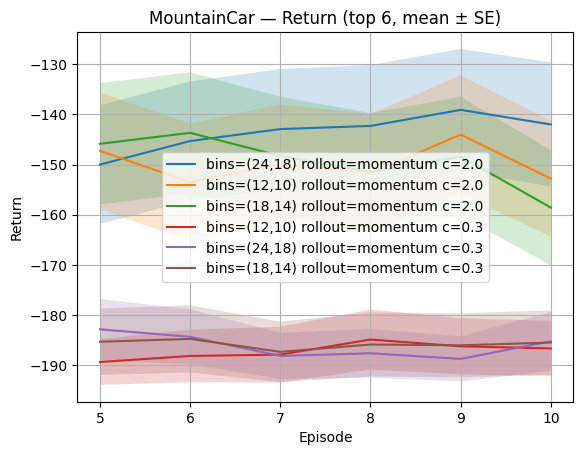

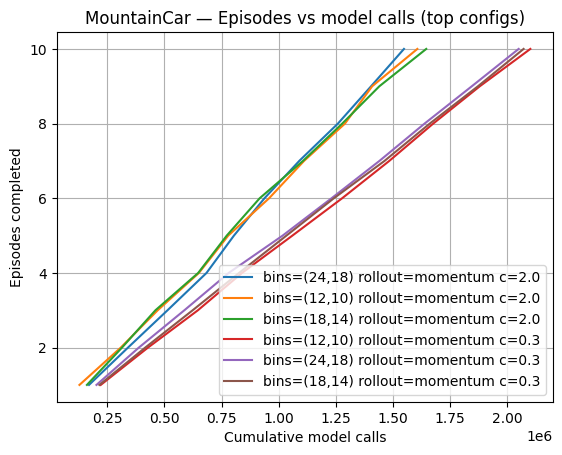

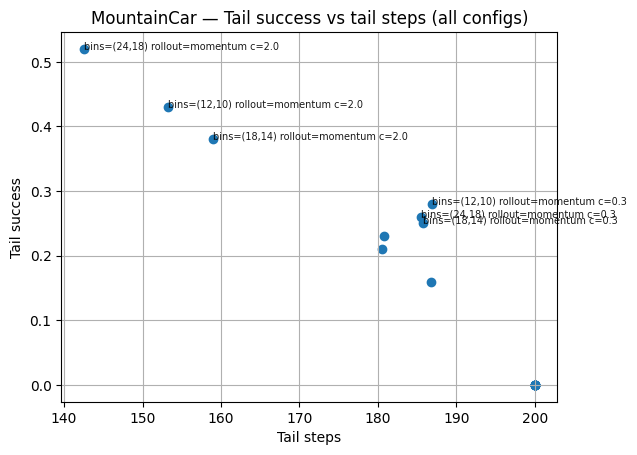


Best config (SINGLE stage):
{'n_x': 24, 'n_v': 18, 'rollout': 'momentum', 'c_ucb': 2.0, 'succ': 0.5199999999999999, 'steps': 142.52, 'ret': -142.0, 'calls': 148704.95, 'label': 'bins=(24,18) rollout=momentum c=2.0', 'idx': 17}

Summary (last 5 episodes): succ=0.520, steps=142.5, ret=-142.00
Results directory: /content/drive/MyDrive/rl_project_results/mcts_mountaincar_single


In [8]:
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/drive")
    OUT_DIR = "/content/drive/MyDrive/rl_project_results/mcts_mountaincar_single"
else:
    OUT_DIR = "./rl_project_results/mcts_mountaincar_single"
os.makedirs(OUT_DIR, exist_ok=True)

def savefig(name: str):
    plt.savefig(os.path.join(OUT_DIR, name), dpi=200, bbox_inches="tight")

def running_mean(x: np.ndarray, w: int) -> np.ndarray:
    if len(x) < w:
        return np.array([])
    c = np.cumsum(np.insert(x, 0, 0.0))
    return (c[w:] - c[:-w]) / w

# ----------------------------
# 1) State keying + rollout policies
# ----------------------------
def mc_state_key_bins(s: np.ndarray, n_x: int, n_v: int) -> Tuple[int, int]:
    x, v = float(s[0]), float(s[1])
    x_norm = (x - MountainCar687.x_min) / (MountainCar687.x_max - MountainCar687.x_min)
    v_norm = (v - MountainCar687.v_min) / (MountainCar687.v_max - MountainCar687.v_min)
    xb = int(np.clip(np.floor(x_norm * n_x), 0, n_x - 1))
    vb = int(np.clip(np.floor(v_norm * n_v), 0, n_v - 1))
    return (xb, vb)

def rollout_random(s: np.ndarray, rng: np.random.Generator) -> int:
    return int(rng.choice([-1, 0, 1]))

def rollout_momentum(s: np.ndarray, rng: np.random.Generator) -> int:
    return 1 if float(s[1]) >= 0.0 else -1

# ----------------------------
# 2) Runner (same metrics protocol as Gridworld)
# ----------------------------
def mcts_mountain_car_run(
    sims_per_decision: int,
    num_episodes: int,
    max_steps: int,
    seed: int,
    n_x: int,
    n_v: int,
    c_ucb: float,
    rollout_policy: str,
    max_depth_planning: int,
    reuse_tree_within_episode: bool = True,
):
    env = MountainCar687(seed=seed)

    def step_fn(s, a, rng):
        return env.sample_step_from(s, a)  # deterministic, does not mutate env

    rp = rollout_momentum if rollout_policy == "momentum" else rollout_random

    planner = MCTSPlanner(
        actions=env.ACTIONS,
        step_fn=step_fn,
        state_key_fn=lambda s: mc_state_key_bins(s, n_x=n_x, n_v=n_v),
        gamma=env.gamma,                  # typically 1.0 for MountainCar setup
        max_depth=int(max_depth_planning),# IMPORTANT: cap simulation depth for speed
        seed=seed,
        tree_policy="ucb",
        c_ucb=float(c_ucb),
        eps_schedule=None,
        force_untried_actions=True,
        rollout_policy=rp,
    )

    lengths = np.zeros(num_episodes, dtype=int)
    returns = np.zeros(num_episodes, dtype=float)
    success = np.zeros(num_episodes, dtype=int)
    model_calls = np.zeros(num_episodes, dtype=int)

    for ep in range(num_episodes):
        env.reset()
        planner.reset_tree()
        planner.reset_model_call_counter()

        s = env.s
        G = 0.0

        for t in range(max_steps):
            a = planner.plan(s, n_simulations=int(sims_per_decision))
            s2, r, done = env.step(a)

            if reuse_tree_within_episode:
                planner.observe_transition_and_reuse(s2, a)
            else:
                planner.reset_tree()

            G += r
            s = s2
            if done:
                success[ep] = 1
                lengths[ep] = t + 1
                break
        else:
            lengths[ep] = max_steps

        returns[ep] = G
        model_calls[ep] = planner.model_calls_total

    return lengths, returns, success, model_calls

def _tail_mean(x: np.ndarray, tail: int) -> float:
    tail = min(tail, len(x))
    return float(np.mean(x[-tail:]))

# ----------------------------
# SINGLE stage sweep
# ----------------------------
MAX_STEPS = 200

FIXED_BUDGET = 15
RUNS = 20
EPISODES = 10
TAIL = 5
TOPK = 6
SMOOTH_W = 5
MAX_DEPTH_PLANNING = 80

BIN_CHOICES = [(12, 10), (18, 14), (24, 18)]
ROLLOUT_CHOICES = ["random", "momentum"]
C_CHOICES = [0.3, 1.0, 2.0]

configs: List[Dict[str, Any]] = []
for (nx, nv) in BIN_CHOICES:
    for rp in ROLLOUT_CHOICES:
        for c in C_CHOICES:
            configs.append({"n_x": nx, "n_v": nv, "rollout": rp, "c_ucb": float(c)})

n_cfg = len(configs)
len_all = np.zeros((n_cfg, RUNS, EPISODES), dtype=int)
ret_all = np.zeros((n_cfg, RUNS, EPISODES), dtype=float)
succ_all = np.zeros((n_cfg, RUNS, EPISODES), dtype=int)
calls_all = np.zeros((n_cfg, RUNS, EPISODES), dtype=int)

print("MountainCar MCTS SINGLE stage starting...")
print(f"  configs={n_cfg}, runs/cfg={RUNS}, eps/cfg={EPISODES}, "
      f"max_steps={MAX_STEPS}, budget={FIXED_BUDGET}, max_depth_planning={MAX_DEPTH_PLANNING}")

rows: List[Dict[str, Any]] = []
t0 = time.time()

for i, cfg in enumerate(configs):
    label = f"bins=({cfg['n_x']},{cfg['n_v']}) rollout={cfg['rollout']:<8s} c={cfg['c_ucb']:.1f}"
    for run in range(RUNS):
        seed = 2000 + 1000 * i + run
        L, G, S, M = mcts_mountain_car_run(
            sims_per_decision=FIXED_BUDGET,
            num_episodes=EPISODES,
            max_steps=MAX_STEPS,
            seed=seed,
            n_x=cfg["n_x"],
            n_v=cfg["n_v"],
            c_ucb=cfg["c_ucb"],
            rollout_policy=cfg["rollout"],
            max_depth_planning=MAX_DEPTH_PLANNING,
            reuse_tree_within_episode=True,
        )
        len_all[i, run] = L
        ret_all[i, run] = G
        succ_all[i, run] = S
        calls_all[i, run] = M

    tail_succ = float(np.mean([_tail_mean(succ_all[i, run], TAIL) for run in range(RUNS)]))
    tail_len  = float(np.mean([_tail_mean(len_all[i, run],  TAIL) for run in range(RUNS)]))
    tail_ret  = float(np.mean([_tail_mean(ret_all[i, run],  TAIL) for run in range(RUNS)]))
    tail_call = float(np.mean([_tail_mean(calls_all[i, run], TAIL) for run in range(RUNS)]))

    rows.append({
        "n_x": int(cfg["n_x"]),
        "n_v": int(cfg["n_v"]),
        "rollout": cfg["rollout"],
        "c_ucb": float(cfg["c_ucb"]),
        "succ": tail_succ,
        "steps": tail_len,
        "ret": tail_ret,
        "calls": tail_call,
        "label": label,
        "idx": i,
    })

    elapsed = time.time() - t0
    print(f"[{i+1:02d}/{n_cfg}] {label} | succ={tail_succ:.3f} steps={tail_len:.1f} ret={tail_ret:.2f} calls={tail_call:.0f} | elapsed={elapsed/60:.1f} min")
    sys.stdout.flush()

rows.sort(key=lambda d: (-d["succ"], d["steps"], -d["ret"], d["calls"]))

csv_path = os.path.join(OUT_DIR, "single_stage_sweep.csv")
with open(csv_path, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=["n_x","n_v","rollout","c_ucb","succ","steps","ret","calls"])
    w.writeheader()
    for d in rows:
        w.writerow({k: d[k] for k in ["n_x","n_v","rollout","c_ucb","succ","steps","ret","calls"]})

best = rows[0]
best_idx = int(best["idx"])

meta_path = os.path.join(OUT_DIR, "single_stage_meta.json")
with open(meta_path, "w") as f:
    json.dump({
        "FIXED_BUDGET": FIXED_BUDGET,
        "RUNS": RUNS, "EPISODES": EPISODES, "MAX_STEPS": MAX_STEPS, "TAIL": TAIL,
        "TOPK": TOPK, "SMOOTH_W": SMOOTH_W, "MAX_DEPTH_PLANNING": MAX_DEPTH_PLANNING,
        "configs": configs,
        "best": best,
    }, f, indent=2)

npz_path = os.path.join(OUT_DIR, "single_stage_arrays.npz")
np.savez(
    npz_path,
    lengths=len_all.astype(np.int16),
    returns=ret_all.astype(np.float32),
    succ=succ_all.astype(np.int8),
    calls=calls_all.astype(np.int32),
)

print("\nMountainCar SINGLE stage ranking — top 10:")
for d in rows[:10]:
    print(f"  {d['label']} | succ={d['succ']:.3f} steps={d['steps']:.1f} ret={d['ret']:.2f} calls={d['calls']:.0f}")
print(f"\nSaved CSV: {csv_path}")
print(f"Saved NPZ: {npz_path}")
print(f"Saved META: {meta_path}")

top = rows[:TOPK]
top_idxs = [int(d["idx"]) for d in top]
top_labels = [d["label"] for d in top]

plt.figure()
for idx, lab in zip(top_idxs, top_labels):
    L = len_all[idx].astype(float)
    mean = L.mean(axis=0)
    se = L.std(axis=0) / np.sqrt(RUNS)
    rm = running_mean(mean, SMOOTH_W)
    rm_se = running_mean(se, SMOOTH_W)
    x = np.arange(len(rm)) + SMOOTH_W
    plt.plot(x, rm, label=lab)
    plt.fill_between(x, rm - rm_se, rm + rm_se, alpha=0.2)
plt.xlabel("Episode"); plt.ylabel("Steps (cap=200)")
plt.title(f"MountainCar — Steps (top {TOPK}, mean ± SE)")
plt.grid(True); plt.legend()
savefig("single_stage_steps_topk.png")
plt.show()

plt.figure()
for idx, lab in zip(top_idxs, top_labels):
    S = succ_all[idx].astype(float)
    mean = S.mean(axis=0)
    se = S.std(axis=0) / np.sqrt(RUNS)
    rm = running_mean(mean, SMOOTH_W)
    rm_se = running_mean(se, SMOOTH_W)
    x = np.arange(len(rm)) + SMOOTH_W
    plt.plot(x, rm, label=lab)
    plt.fill_between(x, rm - rm_se, rm + rm_se, alpha=0.2)
plt.xlabel("Episode"); plt.ylabel("Success rate")
plt.title(f"MountainCar — Success (top {TOPK}, mean ± SE)")
plt.grid(True); plt.legend()
savefig("single_stage_success_topk.png")
plt.show()

plt.figure()
for idx, lab in zip(top_idxs, top_labels):
    R = ret_all[idx]
    mean = R.mean(axis=0)
    se = R.std(axis=0) / np.sqrt(RUNS)
    rm = running_mean(mean, SMOOTH_W)
    rm_se = running_mean(se, SMOOTH_W)
    x = np.arange(len(rm)) + SMOOTH_W
    plt.plot(x, rm, label=lab)
    plt.fill_between(x, rm - rm_se, rm + rm_se, alpha=0.2)
plt.xlabel("Episode"); plt.ylabel("Return")
plt.title(f"MountainCar — Return (top {TOPK}, mean ± SE)")
plt.grid(True); plt.legend()
savefig("single_stage_return_topk.png")
plt.show()

plt.figure()
for idx, lab in zip(top_idxs, top_labels):
    M = calls_all[idx].astype(float)
    cum_model = np.cumsum(M, axis=1).mean(axis=0)
    plt.plot(cum_model, np.arange(1, EPISODES + 1), label=lab)
plt.xlabel("Cumulative model calls"); plt.ylabel("Episodes completed")
plt.title("MountainCar — Episodes vs model calls (top configs)")
plt.grid(True); plt.legend()
savefig("single_stage_episodes_vs_modelcalls_topk.png")
plt.show()

plt.figure()
xs = [d["steps"] for d in rows]
ys = [d["succ"] for d in rows]
plt.scatter(xs, ys)
for d in rows[:TOPK]:
    plt.annotate(d["label"], (d["steps"], d["succ"]), fontsize=7, alpha=0.9)
plt.xlabel("Tail steps"); plt.ylabel("Tail success")
plt.title("MountainCar — Tail success vs tail steps (all configs)")
plt.grid(True)
savefig("single_stage_tail_scatter.png")
plt.show()

K = 5
steps_last = float(len_all[best_idx, :, -K:].mean())
succ_last = float(succ_all[best_idx, :, -K:].mean())
ret_last = float(ret_all[best_idx, :, -K:].mean())
print("\nBest config (SINGLE stage):")
print(best)
print(f"\nSummary (last {K} episodes): succ={succ_last:.3f}, steps={steps_last:.1f}, ret={ret_last:.2f}")
print(f"Results directory: {OUT_DIR}")


Disclaimer:

ChatGPT and google Gemini were used for verifying some bugs I had at points of the implementation, as well as formatting the plots (I am horrible with plotting libraries) and improving the variable naming for easier to follow, as this was a lot more coding than usual assignments.

The underlying code is all written by me.